In [1]:
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import random

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# load data

In [2]:
moviesid=json.load(open('data/movies.json'))
movies = pd.read_csv("data/ml-latest/movies.csv").set_index('movieId')
columns=movies.loc[moviesid]['title'].to_list()

In [3]:
pivot = np.load('data/pivot.npy')
_, test_pivot, _, _ = train_test_split(pivot, range(len(pivot)), random_state=23)
del(pivot)

# load model

In [4]:
cols = json.load(open("model/columns.json"))
corrdf = pd.DataFrame(np.half(np.load("model/corr.npy")), columns=cols, index=cols)
corrdf=corrdf[~corrdf.index.duplicated(keep='first')]

In [5]:
def get_recommendation(movie_name, user_rating):
    sim = corrdf[movie_name]*(user_rating-2.5)
    return sim.sort_values(ascending=False)

get_recommendation("Avengers: Infinity War - Part I (2018)", 4)

Avengers: Infinity War - Part I (2018)     1.500000
Avengers: Infinity War - Part II (2019)    1.167969
Thor: Ragnarok (2017)                      1.158203
Guardians of the Galaxy 2 (2017)           1.021484
Untitled Spider-Man Reboot (2017)          1.012695
                                             ...   
Shakespeare in Love (1998)                -0.157715
Dead Man Walking (1995)                   -0.157715
Get Shorty (1995)                         -0.167114
Four Weddings and a Funeral (1994)        -0.174561
Dances with Wolves (1990)                 -0.191162
Name: Avengers: Infinity War - Part I (2018), Length: 7613, dtype: float16

In [6]:
def get_multirec(tuples):
    return pd.concat([get_recommendation(movie_name, user_rating) for movie_name, user_rating in tuples if user_rating!= 0], axis=1).sum(1).sort_values(ascending=False).index.to_list()

get_multirec([("Avengers: Infinity War - Part I (2018)", 4), ('Untitled Spider-Man Reboot (2017)', 1)])

['Avengers: Infinity War - Part I (2018)',
 'Avengers: Infinity War - Part II (2019)',
 'Deadpool 2 (2018)',
 'Joker (2019)',
 'Thor: Ragnarok (2017)',
 'Interstellar (2014)',
 'Inception (2010)',
 'The Martian (2015)',
 'Green Book (2018)',
 'Wolf of Wall Street, The (2013)',
 'Blade Runner 2049 (2017)',
 'Django Unchained (2012)',
 'Parasite (2019)',
 'Knives Out (2019)',
 '1917 (2019)',
 'Arrival (2016)',
 'Guardians of the Galaxy (2014)',
 'Dune (2021)',
 'Shutter Island (2010)',
 'Dark Knight Rises, The (2012)',
 'Ex Machina (2015)',
 'Dark Knight, The (2008)',
 'Deadpool (2016)',
 'A Quiet Place (2018)',
 'Ford v. Ferrari (2019)',
 'Big Short, The (2015)',
 'Edge of Tomorrow (2014)',
 'Inglourious Basterds (2009)',
 'Avengers, The (2012)',
 'John Wick: Chapter 3 – Parabellum (2019)',
 'The Hateful Eight (2015)',
 'The Imitation Game (2014)',
 'Mad Max: Fury Road (2015)',
 'Whiplash (2014)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Prestige, The (2006)',
 'Annih

# evaluation

In [7]:
testdf=pd.DataFrame(test_pivot, columns=columns)

In [8]:
X_cols, y_cols, _, _ = train_test_split(columns, columns, test_size=0.5)

In [9]:
X=testdf.iloc[:100][X_cols].to_dict('records')
y=testdf.iloc[:100][y_cols].to_dict('records')

In [10]:
def predict(records):
    return [get_multirec(tuple(record.items())) for record in tqdm(records)]

def prep(records):
    return [sorted(record.keys(), key=record.get, reverse=True) for record in tqdm(records)]

h = predict(X)
truth = prep(y)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]
    else:
        print("restricting k to", len(predicted))

    score = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p in predicted:
            score += 1

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [16]:
max_k = 150
ground_truth_all = pd.Series(truth)
h_all = pd.Series(h)
eval_df = pd.DataFrame()
eval_df['h']=h_all
eval_df['truth']=ground_truth_all
precisioin_list = pd.Series([eval_df.apply(lambda row:apk(row['truth'], row['h'], n), axis=1).mean() for n in range(5, max_k+1, 5)], index=range(5, max_k+1, 5))

In [17]:
print("AP@20 is:", eval_df.apply(lambda row:apk(row['truth'], row['h'], 20), axis=1).mean())
print("AP@100 is:", eval_df.apply(lambda row:apk(row['truth'], row['h'], 100), axis=1).mean())

AP@20 is: 0.39800000000000013
AP@100 is: 0.4727


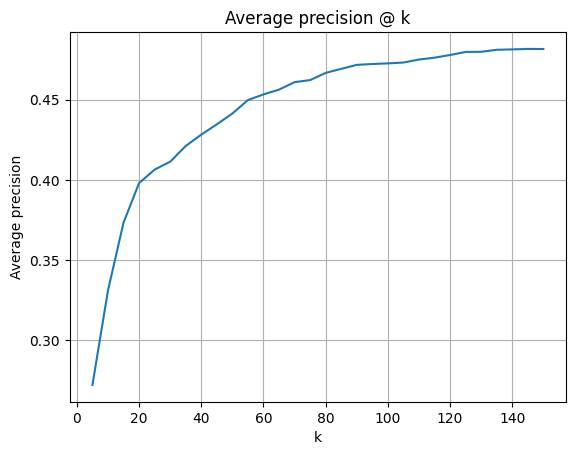

In [14]:
precisioin_list.plot()
plt.xlabel('k')
plt.ylabel('Average precision')
plt.title("Average precision @ k")
plt.grid(True)
plt.show()